https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/overview

Input train_base has 1 048 575 cases, base table where target 0/1 is fullfiled for 47 994 cases, case_id is unique

Input train_static_cb_0 constains riskassesment_302T value in format x% - y% for 40 377 cases, contains 1 048 575 cases 

Another metric for default in table train_static_0_0 is actualdpdtolerance_344P - days past due with tolerance,
where 2 593 values is greater than 0, contains 1 003 757 cases


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statistics
#%pip install cudf
#import cudf
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1500)

In [2]:
def plot_feature_distributions(df, figsize=(16, 12)):
    """
    Plots distribution charts (histograms with KDE) for all features in the DataFrame.
    
    Parameters:
    df : pandas.DataFrame
        The input DataFrame containing the features to plot.
    figsize : tuple, optional
        The size of the figure (default is (16, 12)).
    """
    plt.figure(figsize=figsize)

    # Loop through all columns in the DataFrame
    for i, column in enumerate(df.columns, 1):
        plt.subplot(len(df.columns), 1, i)  # Create subplots for each feature
        sns.histplot(df[column], kde=True)  # Create a histogram with a KDE plot for each feature
        plt.title(f'Distribution of {column}')  # Set the title for each plot

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [3]:
def is_unique(df, column_name):
    return df[column_name].nunique() == len(df)

In [4]:
def fill_feature( df, feature):

  unique_groups = df['num_group1'].unique()

  for group in unique_groups:
      if group != 0:
          # Get non-zero amounts from the current group
          group_non_zero = df.loc[(df['num_group1'] == group) & (df[feature] > 0), feature]

          # Replace the NaN or 0 amounts in num_group1 = 0
          if not group_non_zero.empty:
              mask = (df['num_group1'] == 0) & (df[feature].isna() | (df[feature] == 0))
              # Use the first non-zero value from the current group
              df.loc[mask, feature] = group_non_zero.values[0]  # Or use other logic (e.g., cycle through values)
  return df

In [5]:
# Define file names and corresponding DataFrame names
file_info = [('base'),('person_1'), ('static_0_0'), ('static_0_1'), ('deposit_1'), ('static_cb_0')]
tt_info = [('train'), ('test')]

# Define the folder path
folder='c:\\Users\\Pavel\\Documents\\Learning\\SDA\\Project\\Kaggle_Competition\\Home_Credit_Appl_Prev\\csv_files\\'

# Read the CSV files into DataFrames with dynamic names
for file_name in file_info:
    # Construct full file path
  for tt in tt_info:  
      try:  
        file_path = folder + tt + '_' + file_name + '.csv'
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path, low_memory=False)
        
        # Use globals() to dynamically create the DataFrame variable
        df_name = tt + '_' + file_name + '_df'
        globals()[df_name] = df
        print(f"Loaded {file_path} into {df_name}")
      except FileNotFoundError:
         print(f"File not found: {file_path}")



Loaded c:\Users\Pavel\Documents\Learning\SDA\Project\Kaggle_Competition\Home_Credit_Appl_Prev\csv_files\train_base.csv into train_base_df
Loaded c:\Users\Pavel\Documents\Learning\SDA\Project\Kaggle_Competition\Home_Credit_Appl_Prev\csv_files\test_base.csv into test_base_df
Loaded c:\Users\Pavel\Documents\Learning\SDA\Project\Kaggle_Competition\Home_Credit_Appl_Prev\csv_files\train_person_1.csv into train_person_1_df
Loaded c:\Users\Pavel\Documents\Learning\SDA\Project\Kaggle_Competition\Home_Credit_Appl_Prev\csv_files\test_person_1.csv into test_person_1_df
Loaded c:\Users\Pavel\Documents\Learning\SDA\Project\Kaggle_Competition\Home_Credit_Appl_Prev\csv_files\train_static_0_0.csv into train_static_0_0_df
Loaded c:\Users\Pavel\Documents\Learning\SDA\Project\Kaggle_Competition\Home_Credit_Appl_Prev\csv_files\test_static_0_0.csv into test_static_0_0_df
Loaded c:\Users\Pavel\Documents\Learning\SDA\Project\Kaggle_Competition\Home_Credit_Appl_Prev\csv_files\train_static_0_1.csv into train_st

In [6]:
#DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False. df = pd.read_csv(file_path, dtype={16: str})
train_static_0_1_df = train_static_0_1_df.rename(columns={col: col + '_1' for col in train_static_0_1_df.columns if col != 'case_id'})
print(train_base_df.shape)
print(train_person_1_df.shape)
print(train_static_0_0_df.shape)
print(train_static_0_1_df.shape)

(1526659, 5)
(2973991, 37)
(1003757, 168)
(522902, 168)


In [7]:
train_base_df.head()

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1


In [8]:
train_base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   case_id        1526659 non-null  int64 
 1   date_decision  1526659 non-null  object
 2   MONTH          1526659 non-null  int64 
 3   WEEK_NUM       1526659 non-null  int64 
 4   target         1526659 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 58.2+ MB


In [9]:
train_static_0_0_df.describe(include='all')

,case_id,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_136L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,equalityempfrom_62L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,interestrategrace_34L,isbidproduct_1095L,isbidproductrequest_292L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcommoditytypec_5251766M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastdependentsnum_448L,lastotherinc_902A,lastotherlnsexpense_631A,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastrepayingdate_696D,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxannuity_4075009A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,payvacationpostpone_4187118D,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,previouscontdistrict_112M,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,validfrom_1069D
count,1.003757e+06,707071.000000,574903.000000,1.003757e+06,1.003755e+06,1.003757e+06,1.003757e+06,1.003757e+06,1.003757e+06,1.003757e+06,1.003757e+06,577626.000000,345754.000000,218032.000000,674485.000000,570036.000000,69807.000000,488464.000000,4.0

In [10]:
train_static_0_0_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003757 entries, 0 to 1003756
Data columns (total 168 columns):
 #    Column                           Dtype  
---   ------                           -----  
 0    case_id                          int64  
 1    actualdpdtolerance_344P          float64
 2    amtinstpaidbefduel24m_4187115A   float64
 3    annuity_780A                     float64
 4    annuitynextmonth_57A             float64
 5    applicationcnt_361L              float64
 6    applications30d_658L             float64
 7    applicationscnt_1086L            float64
 8    applicationscnt_464L             float64
 9    applicationscnt_629L             float64
 10   applicationscnt_867L             float64
 11   avgdbddpdlast24m_3658932P        float64
 12   avgdbddpdlast3m_4187120P         float64
 13   avgdbdtollast24m_4525197P        float64
 14   avgdpdtolclosure24_3658938P      float64
 15   avginstallast24m_3658937A        float64
 16   avglnamtstart24m_4525187A        f

In [11]:
print(is_unique(train_base_df, 'case_id'))
print(train_base_df['target'].sum())
print(is_unique(train_static_0_0_df, 'case_id'))
print(is_unique(train_static_0_1_df, 'case_id'))

True
47994
True
True


In [12]:
train_base_df['date_decision_dt'] = train_base_df.apply(lambda row: datetime.datetime.strptime(row['date_decision'], '%Y-%m-%d').date(), axis=1)
train_base_df['date_decision'] = train_base_df.apply(lambda row: datetime.datetime.strptime(row['date_decision'], '%Y-%m-%d'), axis=1)
train_base_df['year_decision'] = train_base_df.apply(lambda row: int((row['date_decision_dt'].year)), axis=1)
print(train_base_df['date_decision_dt'].min())
print(train_base_df['date_decision_dt'].max())

2019-01-01
2020-10-05


In [13]:
train_person_1_df.query('num_group1 == 0').count()

case_id                      1526659
birth_259D                   1526659
birthdate_87D                  12458
childnum_185L                      0
contaddr_district_15M        1526659
contaddr_matchlist_1032L     1526218
contaddr_smempladdr_334L     1526218
contaddr_zipcode_807M        1526659
education_927M               1526659
empl_employedfrom_271D        566701
empl_employedtotal_800L       528315
empl_industry_691L            522236
empladdr_district_926M       1526659
empladdr_zipcode_114M        1526659
familystate_447L              728613
gender_992L                    12458
housetype_905L                100818
housingtype_772L                   0
incometype_1044T             1526659
isreference_387L               12458
language1_981M               1526659
mainoccupationinc_384A       1526659
maritalst_703L                     1
num_group1                   1526659
personindex_1023L            1526659
persontype_1072L             1526659
persontype_792L              1526659
r

In [14]:
def update_columns_based_on_case_id(df, columns_to_update):
    """
    Updates the specified columns in the DataFrame based on matching `case_id` 
    between rows where `num_group1 == 0` and `num_group1 == 1`.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns_to_update (list): List of column names (as strings) to update.

    Returns:
    pd.DataFrame: The updated DataFrame.
    """
    for col in columns_to_update:
        # Filter rows where num_group1 == 0 and where num_group1 == 1
        df_0 = df.query('num_group1 == 0')[['case_id', col]]
        df_1 = df.query('num_group1 == 1')[['case_id', col]]
        df_2 = df.query('num_group1 == 2')[['case_id', col]]

        # Merge the data on 'case_id', num_group1 == 2 first
        merged_df_2 = pd.merge(df_0, df_2, on='case_id', how='inner', suffixes=('_0', '_2'))
        merged_df_1 = pd.merge(df_0, df_1, on='case_id', how='inner', suffixes=('_0', '_1'))
        
        # Update the column in the original DataFrame where num_group1 == 0
        df.loc[df['num_group1'] == 0, col] = df.loc[df['num_group1'] == 0, 'case_id'].map(
            merged_df_2.set_index('case_id')[f'{col}_2'])
        
        df.loc[df['num_group1'] == 0, col] = df.loc[df['num_group1'] == 0, 'case_id'].map(
            merged_df_1.set_index('case_id')[f'{col}_1'])

    return df

In [15]:
columns_to_update = (['childnum_185L', 'maritalst_703L', 'housingtype_772L', 'relationshiptoclient_415T', 'relationshiptoclient_642T', 'remitter_829L'])
train_person_1_df = update_columns_based_on_case_id(train_person_1_df, columns_to_update)

In [16]:
train_deposit_1_df.head(5)

,case_id,amount_416A,contractenddate_991D,num_group1,openingdate_313D
0,225,0.00000,NaN,0,2016-08-16
1,331,260.37400,2018-03-18,0,2015-03-19
2,358,0.00000,NaN,0,2014-09-02
3,390,203.60200,2017-09-30,1,2015-10-01
4,390,223.68001,NaN,2,2016-06-08


In [17]:
train_deposit_1_df = fill_feature(train_deposit_1_df, 'amount_416A')

In [18]:
train_static_cb_0_df = train_static_cb_0_df[['case_id', 'for3years_128L', 'maritalst_385M', 'pmtcount_693L', 'pmtssum_45A', 'pmtscount_423L', 'riskassesment_302T', 'riskassesment_940T']]
train_static_cb_0_df[['riskassesmentlow', 'riskassesmenthigh']] = train_static_cb_0_df['riskassesment_302T'].str.extract(r'(\d+)%\s*-\s*(\d+)%')
#

In [19]:
# count of rows must be 1 526 659 
train_rich_df = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(train_base_df, train_person_1_df.query('num_group1 == 0'), how='inner', on='case_id'), train_static_0_0_df, how='left', on='case_id'), train_static_0_1_df, how='left', on='case_id'), train_deposit_1_df.query('num_group1 == 0')[['case_id','amount_416A']], how='left', on='case_id'), train_static_cb_0_df, how='left', on='case_id')
print(train_rich_df.shape)

(1526659, 387)


In [20]:
train_rich_df.head(5)

,case_id,date_decision,MONTH,WEEK_NUM,target,date_decision_dt,year_decision,birth_259D,birthdate_87D,childnum_185L,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,contaddr_zipcode_807M,education_927M,empl_employedfrom_271D,empl_employedtotal_800L,empl_industry_691L,empladdr_district_926M,empladdr_zipcode_114M,familystate_447L,gender_992L,housetype_905L,housingtype_772L,incometype_1044T,isreference_387L,language1_981M,mainoccupationinc_384A,maritalst_703L,num_group1,personindex_1023L,persontype_1072L,persontype_792L,registaddr_district_1083M,registaddr_zipcode_184M,relationshiptoclient_415T,relationshiptoclient_642T,remitter_829L,role_1084L,role_993L,safeguarantyflag_411L,sex_738L,type_25L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_136L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,equalityempfrom_62L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,interestrategrace_34L,isbidproduct_1095L,isbidproductrequest_292L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcommoditytypec_5251766M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastdependentsnum_448L,lastotherinc_902A,lastotherlnsexpense_631A,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastrepayingdate_696D,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxannuity_4075009A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,payvacationpostpone_4187118D,pctinstlsallpaidearl3d

In [21]:
pd.options.mode.copy_on_write = True #odstranění warningu
y = train_rich_df[['case_id', 'target']]
y.rename(columns = {'case_id':'index'}, inplace = True)
y = y.drop(columns=['index'])
new_submission = train_rich_df[["case_id"]] #Uložení Id bokem
y.reset_index(drop=True).reset_index()
#y['Id'] = y['Id'] -1 ?
y.head()

,target
0,0
1,0
2,0
3,0
4,1


In [22]:
train_rich_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Columns: 387 entries, case_id to riskassesmenthigh
dtypes: datetime64[ns](1), float64(267), int64(6), object(113)
memory usage: 4.4+ GB


In [23]:
def fill_average_date(df, columns_to_update):
    for column_name in columns_to_update:
        # Step 1: Select only rows where the date is not null
        non_null_dates = df[column_name].dropna()

        # Step 2: Convert the date column from string to datetime format
        non_null_dates = pd.to_datetime(non_null_dates, format='%Y-%m-%d', errors='coerce') #do not convert to date here

        # Step 3: Calculate the mean date (in datetime format)
        average_date = non_null_dates.mean().date()

        # Step 4: Fill the null values in the original dataframe with the calculated average date
        df[column_name] = pd.to_datetime(df[column_name], format='%Y-%m-%d', errors='coerce').dt.date
        df[column_name] = df[column_name].fillna(average_date)

    return df

columns_to_update = (['empl_employedfrom_271D'])

# Call the function to fill null values with average date
train_rich_df = fill_average_date(train_rich_df, columns_to_update)

In [33]:
# Example of a safe float function
def safe_float(x):
    if isinstance(x, (int, float)):
        return x
    if isinstance(x, str):
        try:
            return float(x)
        except ValueError:
            return np.nan
    return np.nan

# Dictionary-based configuration for handling missing values
# Format: 'column_name': (method, optional_argument)
imputation_config = {
    'childnum_185L': ('fillna', 0),
    'empl_industry_691L': ('fillna', 'OTHER'),
    'familystate_447L': ('fillna_column', 'maritalst_703L'),
    'housetype_905L': ('fillna_column', 'housingtype_772L'),
    'safeguarantyflag_411L': ('fillna', True),
    'isreference_387L': ('fillna', False),
    'relationshiptoclient_415T': ('fillna_column', 'relationshiptoclient_642T'),
    'remitter_829L': ('fillna', True),
    'role_993L': ('apply_lambda', lambda row: int(1 if pd.notnull(row['role_993L']) else 0)),
    'contaddr_smempladdr_334L': ('fillna', False),
    'contaddr_matchlist_1032L': ('fillna', True),
    'actualdpdtolerance_344P' : ('fillna', 0), 'actualdpdtolerance_344P_0' : ('fillna', 0),    'actualdpdtolerance_344P_1' : ('fillna', 0),
    'amtinstpaidbefduel24m_4187115A' : ('fillna', 0),    'amtinstpaidbefduel24m_4187115A_1' : ('fillna', 0),
    'annuitynextmonth_57A' : ('fillna', 0),    'annuitynextmonth_57A_1' : ('fillna', 0),
    'applicationcnt_361L' : ('fillna', 0),    'applicationcnt_361L_1' : ('fillna', 0),
    'applications30d_658L' : ('fillna', 0),    'applications30d_658L_1' : ('fillna', 0),
    'applicationscnt_1086L' : ('fillna', 0),    'applicationscnt_1086L_1' : ('fillna', 0),
    'applicationscnt_464L' : ('fillna', 0),    'applicationscnt_464L_1' : ('fillna', 0),
    'applicationscnt_629L' : ('fillna', 0),    'applicationscnt_629L_1' : ('fillna', 0),
    'applicationscnt_867L' : ('fillna', 0),    'applicationscnt_867L_1' : ('fillna', 0),
    'annuity_780A' : ('mean', 0),    'annuity_780A_1' : ('mean', 0),
    'annuitynextmonth_57A' : ('mean', 0),    'annuitynextmonth_57A_1' : ('mean', 0),
    'avgdbddpdlast24m_3658932P' : ('fillna', -1),    'avgdbddpdlast24m_3658932P_1' : ('fillna', -1),
    'avgdbddpdlast3m_4187120P' : ('fillna', -1),    'avgdbddpdlast3m_4187120P_1' : ('fillna', -1),
    'avgdbdtollast24m_4525197P' : ('fillna', -1),    'avgdbdtollast24m_4525197P_1' : ('fillna', -1),
    'avgdpdtolclosure24_3658938P' : ('fillna', 0),    'avgdpdtolclosure24_3658938P_1' : ('fillna', 0),
    'avginstallast24m_3658937A' : ('mode', 0),    'avginstallast24m_3658937A_1' : ('mode', 0),
    'avglnamtstart24m_4525187A' : ('mode', 0),    'avglnamtstart24m_4525187A_1' : ('mode', 0),
    'avgmaxdpdlast9m_3716943P' : ('fillna', 0),    'avgmaxdpdlast9m_3716943P_1' : ('fillna', 0),
    'avgoutstandbalancel6m_4187114A' : ('fillna', 0),    'avgoutstandbalancel6m_4187114A_1' : ('fillna', 0),
    'avgpmtlast12m_4525200A' : ('fillna', 0),    'avgpmtlast12m_4525200A_1' : ('fillna', 0),
    'cardtype_51L' : ('fillna', 'INSTANT'),    'cardtype_51L_1' : ('fillna', 'INSTANT'),
    'clientscnt3m_3712950L': ('fillna', 0),    'clientscnt3m_3712950L_1': ('fillna', 0),
    'clientscnt12m_3712952L': ('fillna', 0),    'clientscnt12m_3712952L_1': ('fillna', 0),
    'clientscnt6m_3712949L': ('fillna', 0),    'clientscnt6m_3712949L_1': ('fillna', 0),
    'clientscnt_100L': ('fillna', 0),    'clientscnt_100L_1': ('fillna', 0),
    'clientscnt_1022L': ('fillna', 0),    'clientscnt_1022L_1': ('fillna', 0),
    'clientscnt_1071L': ('fillna', 0),    'clientscnt_1071L_1': ('fillna', 0),
    'clientscnt_1130L': ('fillna', 0),    'clientscnt_1130L_1': ('fillna', 0),
    'clientscnt_136L': ('fillna', 0),    'clientscnt_136L_1': ('fillna', 0),
    'clientscnt_157L': ('fillna', 0),    'clientscnt_157L_1': ('fillna', 0),
    'clientscnt_257L': ('fillna', 0),    'clientscnt_257L_1': ('fillna', 0),
    'clientscnt_304L': ('fillna', 0),    'clientscnt_304L_1': ('fillna', 0),
    'clientscnt_360L': ('fillna', 0),    'clientscnt_360L_1': ('fillna', 0),
    'clientscnt_493L': ('fillna', 0),    'clientscnt_493L_1': ('fillna', 0),
    'clientscnt_533L': ('fillna', 0),    'clientscnt_533L_1': ('fillna', 0),
    'clientscnt_887L': ('fillna', 0),    'clientscnt_887L_1': ('fillna', 0),
    'clientscnt_946L': ('fillna', 0),    'clientscnt_946L_1': ('fillna', 0),
    'cntincpaycont9m_3716944L': ('fillna', 0),    'cntincpaycont9m_3716944L_1': ('fillna', 0),
    'cntpmts24_3658933L': ('fillna', 0),    'cntpmts24_3658933L_1': ('fillna', 0),
    'commnoinclast6m_3546845L': ('fillna', 0),    'commnoinclast6m_3546845L_1': ('fillna', 0),
    'credamount_770A' : ('mean', 0),    'credamount_770A_1' : ('mean', 0),
    'currdebt_22A' : ('fillna', 0),    'currdebt_22A_1' : ('fillna', 0),
    'currdebtcredtyperange_828A' : ('fillna', 0),    'currdebtcredtyperange_828A_1' : ('fillna', 0),
    'daysoverduetolerancedd_3976961L' : ('fillna', 0),    'daysoverduetolerancedd_3976961L_1' : ('fillna', 0),
    'deferredmnthsnum_166L' : ('fillna', 0),    'deferredmnthsnum_166L_1' : ('fillna', 0),
    'disbursedcredamount_1113A' : ('fillna', 0),    'disbursedcredamount_1113A_1' : ('fillna', 0),
    'downpmt_116A' : ('safefloat', 0),    'downpmt_116A' : ('fillna', 0),
    'downpmt_116A_1' : ('safefloat', 0),    'downpmt_116A_1' : ('fillna', 0),
    'eir_270L' : ('mean', 0),    'eir_270L_1' : ('mean', 0),
    'equalitydataagreement_891L' : ('fillna', False),    'equalitydataagreement_891L_1' : ('fillna', False),
    'equalityempfrom_62L' : ('fillna', False),    'equalityempfrom_62L_1' : ('fillna', False),
    'homephncnt_628L' : ('fillna', 0),    'homephncnt_628L_1' : ('fillna', 0),
    'inittransactionamount_650A' : ('fillna', 0),    'inittransactionamount_650A_1' : ('fillna', 0),
    'interestrate_311L' : ('mean', 0),    'interestrate_311L_1' : ('mean', 0),
    'interestrategrace_34L' : ('fillna', 0),    'interestrategrace_34L_1' : ('fillna', 0),
    'isbidproduct_1095L' : ('fillna', False),    'isbidproduct_1095L_1' : ('fillna', False),
    'isdebitcard_729L' : ('fillna', False),    'isdebitcard_729L_1' : ('fillna', False),
    'lastapprcredamount_781A' : ('mean', 0),    'lastapprcredamount_781A_1' : ('mean', 0),
    'lastcancelreason_561M' : ('fillna', 'a55475b1'),    'lastcancelreason_561M_1' : ('fillna', 'a55475b1'),
    'lastdependentsnum_448L' : ('fillna', 0),    'lastdependentsnum_448L_1' : ('fillna', 0),
    'lastotherinc_902A' : ('mean', 0),    'lastotherinc_902A_1' : ('mean', 0),
    'lastotherlnsexpense_631A' : ('mean', 0),    'lastotherlnsexpense_631A_1' : ('mean', 0),
    'lastrejectreason_759M': ('fillna', 0), 'lastrejectreason_759M_1': ('fillna', 0),
    'lastrejectreasonclient_4145040M': ('fillna', 0), 'lastrejectreasonclient_4145040M_1': ('fillna', 0),    
    'lastrejectcommoditycat_161M' : ('fillna', 'a55475b1'),    'lastrejectcommoditycat_161M_1' : ('fillna', 'a55475b1'),
    'lastrejectcommodtypec_5251769M' : ('fillna', 'a55475b1'),    'lastrejectcommodtypec_5251769M_1' : ('fillna', 'a55475b1'),
    'lastapprcommoditycat_1041M_1' : ('fillna', 'a55475b1'),  
    'lastapprcommoditytypec_5251766M_1' : ('fillna', 'a55475b1'),
    'lastrejectcredamount_222A' : ('mean', 0),    'lastrejectcredamount_222A_1' : ('mean', 0),
    'maininc_215A' : ('mean', 0),    'maininc_215A_1' : ('mean', 0),
    'maxannuity_159A' : ('mean', 0),    'maxannuity_159A_1' : ('mean', 0),
    'maxannuity_4075009A' : ('mean', 0),    'maxannuity_4075009A_1' : ('mean', 0),
    'maxdbddpdlast1m_3658939P' : ('mean<0', 0),    'maxdbddpdlast1m_3658939P_1' : ('mean<0', 0),
    'maxdbddpdtollast12m_3658940P' : ('mean<0', 0),    'maxdbddpdtollast12m_3658940P_1' : ('mean<0', 0),
    'maxdbddpdtollast6m_4187119P' : ('mean<0', 0),    'maxdbddpdtollast6m_4187119P_1' : ('mean<0', 0),
    'maxdebt4_972A' : ('fillna', 0),    'maxdebt4_972A_1' : ('fillna', 0),
    'maxdpdfrom6mto36m_3546853P' : ('fillna', 0),    'maxdpdfrom6mto36m_3546853P_1' : ('fillna', 0),
    'maxdpdinstlnum_3546846P' : ('fillna', 0),    'maxdpdinstlnum_3546846P_1' : ('fillna', 0),
    'maxdpdlast12m_727P' : ('fillna', 0),    'maxdpdlast12m_727P_1' : ('fillna', 0),
    'maxdpdlast24m_143P' : ('fillna', 0),    'maxdpdlast24m_143P_1' : ('fillna', 0),
    'maxdpdlast3m_392P' : ('fillna', 0),    'maxdpdlast3m_392P_1' : ('fillna', 0),
    'maxdpdlast6m_474P' : ('fillna', 0),    'maxdpdlast6m_474P_1' : ('fillna', 0),
    'maxdpdlast9m_1059P' : ('fillna', 0),    'maxdpdlast9m_1059P_1' : ('fillna', 0),
    'maxdpdtolerance_374P' : ('fillna', 0),    'maxdpdtolerance_374P_1' : ('fillna', 0),
    'maxinstallast24m_3658928A' : ('mean', 0),    'maxinstallast24m_3658928A_1' : ('mean', 0),
    'maxlnamtstart6m_4525199A' : ('mean', 0),    'maxlnamtstart6m_4525199A_1' : ('mean', 0),
    'maxoutstandbalancel12m_4187113A' : ('mean', 0),    'maxoutstandbalancel12m_4187113A_1' : ('mean', 0),
    'maxpmtlast3m_4525190A' : ('mean', 0),    'maxpmtlast3m_4525190A_1' : ('mean', 0),
    'mindbddpdlast24m_3658935P' : ('mean<0', 0),    'mindbddpdlast24m_3658935P_1' : ('mean<0', 0),
    'mindbdtollast24m_4525191P' : ('mode', 0),    'mindbdtollast24m_4525191P_1' : ('mode', 0),
    'mobilephncnt_593L' : ('fillna', 1),    'mobilephncnt_593L_1' : ('fillna', 1),
    'monthsannuity_845L' : ('mean', 0),    'monthsannuity_845L_1' : ('mean', 0),
    'numactivecreds_622L' : ('fillna', 0),    'numactivecreds_622L_1' : ('fillna', 0),
    'numactivecredschannel_414L' : ('fillna', 0),    'numactivecredschannel_414L_1' : ('fillna', 0),
    'numactiverelcontr_750L' : ('fillna', 0),    'numactiverelcontr_750L_1' : ('fillna', 0),
    'numcontrs3months_479L' : ('fillna', 0),     'numcontrs3months_479L_1' : ('fillna', 0),
    'numincomingpmts_3546848L' : ('mode', 0),    'numincomingpmts_3546848L_1' : ('mode', 0),
    'numinstlallpaidearly3d_817L' : ('fillna', 0),    'numinstlallpaidearly3d_817L_1' : ('fillna', 0),
    'numinstls_657L' : ('mean', 0),     'numinstls_657L_1' : ('mean', 0),
    'numinstlsallpaid_934L' : ('mean', 0),    'numinstlsallpaid_934L_1' : ('mean', 0),                                
    'numinstlswithdpd10_728L' : ('fillna', 0),    'numinstlswithdpd10_728L_1' : ('fillna', 0),
    'numinstlswithdpd5_4187116L' : ('fillna', 0),    'numinstlswithdpd5_4187116L_1' : ('fillna', 0),
    'numinstlswithoutdpd_562L' : ('mean', 0),    'numinstlswithoutdpd_562L_1' : ('mean', 0),
    'numinstmatpaidtearly2d_4499204L' : ('fillna', 0),    'numinstmatpaidtearly2d_4499204L_1' : ('fillna', 0),
    'numinstpaid_4499208L' : ('mean', 0),    'numinstpaid_4499208L_1' : ('mean', 0),    
    'numinstpaidearly3d_3546850L' : ('fillna', 0),    'numinstpaidearly3d_3546850L_1' : ('fillna', 0),
    'numinstpaidearly3dest_4493216L' : ('fillna', 0),    'numinstpaidearly3dest_4493216L_1' : ('fillna', 0),
    'numinstpaidearly5d_1087L' : ('fillna', 0),    'numinstpaidearly5d_1087L_1' : ('fillna', 0),
    'numinstpaidearly5dest_4493211L' : ('fillna', 0),    'numinstpaidearly5dest_4493211L_1' : ('fillna', 0),    
    'numinstpaidearly5dobd_4499205L' : ('fillna', 0),    'numinstpaidearly5dobd_4499205L_1' : ('fillna', 0),
    'numinstpaidearly_338L' : ('fillna', 0),    'numinstpaidearly_338L_1' : ('fillna', 0),
    'numinstpaidearlyest_4493214L' : ('fillna', 0),    'numinstpaidearlyest_4493214L_1' : ('fillna', 0),
    'numinstpaidlastcontr_4325080L' : ('mean', 0),    'numinstpaidlastcontr_4325080L_1' : ('mean', 0),
    'numinstpaidlate1d_3546852L' : ('fillna', 0),    'numinstpaidlate1d_3546852L_1' : ('fillna', 0),
    'numinstregularpaid_973L' : ('fillna', 0),    'numinstregularpaid_973L_1' : ('fillna', 0),
    'numinstregularpaidest_4493210L' : ('fillna', 0),    'numinstregularpaidest_4493210L_1' : ('fillna', 0),
    'numinsttopaygr_769L' : ('fillna', 0),    'numinsttopaygr_769L_1' : ('fillna', 0),
    'numinstunpaidmax_3546851L' : ('fillna', 0),    'numinstunpaidmax_3546851L_1' : ('fillna', 0),
    'numnotactivated_1143L' : ('fillna', 0),    'numnotactivated_1143L_1' : ('fillna', 0),
    'numpmtchanneldd_318L' : ('fillna', 0),    'numpmtchanneldd_318L_1' : ('fillna', 0),
    'numrejects9m_859L' : ('fillna', 0),    'numrejects9m_859L_1' : ('fillna', 0),
    'pmtnum_254L' : ('fillna', 0),    'pmtnum_254L_1' : ('fillna', 0),
    'price_1097A' : ('fillna', 0),    'price_1097A_1' : ('fillna', 0),
    'sellerplacecnt_915L' : ('fillna', 0),    'sellerplacecnt_915L_1' : ('fillna', 0),
    'sellerplacescnt_216L' : ('fillna', 0),    'sellerplacescnt_216L_1' : ('fillna', 0),
    'sumoutstandtotal_3546847A' : ('fillna', 0),    'sumoutstandtotal_3546847A_1' : ('fillna', 0),
    'totaldebt_9A' : ('fillna', 0),    'totaldebt_9A_1' : ('fillna', 0),
    'totalsettled_863A' : ('fillna', 0),    'totalsettled_863A_1' : ('fillna', 0),
    'twobodfilling_608L' : ('fillna', 'FO'),    'twobodfilling_608L_1' : ('fillna', 'FO'),
    'typesuite_864L' : ('fillna', 'NO'),    'typesuite_864L_1' : ('fillna', 'NO'),
    'amount_416A' : ('mean', 0),    'amount_416A_1' : ('mean', 0),
    'totalsettled_863A' : ('fillna', 0),    'totalsettled_863A_1' : ('fillna', 0),
    'for3years_128L' : ('fillna', 0),    'for3years_128L_1' : ('fillna', 0),
    'pmtscount_423L' : ('mode', 0),    'pmtscount_423L_1' : ('mode', 0),
    'pmtcount_693L' : ('mode', 0),    'pmtcount_693L_1' : ('mode', 0),
    'pmtssum_45A' : ('fillna', 0),    'pmtssum_45A_1' : ('fillna', 0),
    'riskassesment_940T' : ('fillna', 0),    'riskassesment_940T_1' : ('fillna', 0),
    'riskassesmentlow' : ('mean', 0),    'riskassesmentlow_1' : ('mean', 0),
    'riskassesmenthigh' : ('mean', 0),    'riskassesmenthigh_1' : ('mean', 0),
    'datefirstoffer_1144D' : ('timedelta', 3),    'datefirstoffer_1144D_1' : ('timedelta', 3),
    'datelastinstal40dpd_247D' : ('time', '2261-12-31'),    'datelastinstal40dpd_247D_1' : ('time', '2261-12-31'),
    'datelastunpaid_3546854D' : ('time', '2261-12-31'),    'datelastunpaid_3546854D_1' : ('time', '2261-12-31'),
    'dtlastpmtallstes_4499206D' : ('time', '2261-12-31'),    'dtlastpmtallstes_4499206D_1' : ('time', '2261-12-31'),
    'firstclxcampaign_1125D' : ('timedelta', 14),    'firstclxcampaign_1125D_1' : ('timedelta', 14),
    'firstdatedue_489D' : ('timedelta', 30),    'firstdatedue_489D_1' : ('timedelta', 30),
    'lastactivateddate_801D' : ('time', '2261-12-31'),    'lastactivateddate_801D_1' : ('time', '2261-12-31'),
    'lastapplicationdate_877D' : ('timedelta', 3),    'lastapplicationdate_877D_1' : ('timedelta', 3),
    'lastapprdate_640D' : ('time', '1900-12-31'),    'lastapprdate_640D_1' : ('time', '1900-12-31'),
    'lastdelinqdate_224D' : ('time', '1900-12-31'),    'lastdelinqdate_224D_1' : ('time', '1900-12-31'),
    'lastrejectdate_50D' : ('time', '1900-12-31'),    'lastrejectdate_50D_1' : ('time', '1900-12-31'),
    'lastrepayingdate_696D' : ('time', '1900-12-31'),    'lastrepayingdate_696D_1' : ('time', '1900-12-31'),
    'validfrom_1069D' : ('time', 14),    'validfrom_1069D_1' : ('time', 14),


    #'' : ('timedelta', 0),
    #'_1' : ('timedelta', 0),
    #'' : ('time', 14),
    #'' : ('time', 14),
    # Add further columns as needed
}

def apply_imputation(df, config):
    for column, (method, arg) in config.items():
        if column in df.columns:
            if method == 'fillna':
                df[column] = df[column].fillna(arg)
            elif method == 'fillna_column':
                df[column] = df[column].fillna(df[arg])
            elif method == 'apply_lambda':
                df[column] = df.apply(arg, axis=1)
            elif method == 'safe_float':
                df[column] = df[column].apply(safe_float)
            elif method == 'mean':
                df[column] = df[column].apply(safe_float)
                df[column] = df[column].fillna(df[column].mean())
            elif method == 'mean<0':
                df[column] = df[column].apply(safe_float)                
                df[column] = df[column].fillna(df[column][df[column] < 0].mean())
            elif method == 'mode':
                df[column] = df[column].apply(safe_float)
                df[column] = statistics.mode(df[column])
            elif method == 'timedelta':                
                df[column] = df[column].fillna(df['date_decision']-pd.Timedelta(days=arg))
            elif method == 'time':    
                df[column] = df[column].fillna(pd.to_datetime(arg).date())
    return df

# Example configuration for derived columns
derived_columns_config = {
    'age': ('subtract_dates', 'date_decision', 'birth_259D'),
    'empl_employedtotal_800L': ('subtract_dates_days', 'date_decision_dt', 'empl_employedfrom_271D')
}

def apply_derived_columns(df, config):
    for column, (operation, col1, col2) in config.items():
        if operation == 'subtract_dates':
            df[column] = pd.to_datetime(df[col1], errors='coerce').dt.year - pd.to_datetime(df[col2], errors='coerce').dt.year
        elif operation == 'subtract_dates_days':
            df[column] = df.apply(
                lambda row: (row[col1] - row[col2]).days if pd.notnull(row[col1]) and pd.notnull(row[col2]) else 0,
                axis=1
            )
    return df

def preprocess_data(df, imputation_config, derived_columns_config, target_column='target'):
    # Drop the target column if it exists
    if target_column in df.columns:
        df.drop(columns=[target_column], inplace=True)

    # Apply imputation for missing values
    df = apply_imputation(df, imputation_config)

    # Apply derived columns calculations
    df = apply_derived_columns(df, derived_columns_config)

    return df


In [34]:
train_rich_df = preprocess_data(train_rich_df, imputation_config, derived_columns_config).copy()

In [ ]:
feature = 'lastapprcommoditycat_1041M_1'
#train_rich_df[feature] = train_rich_df[feature].astype(float)
def show_stat(feature):
  print(statistics.mode(train_rich_df[feature]))
  print(train_rich_df[feature].mean())
  print(train_rich_df[feature].min())
  print(train_rich_df[feature].max())
  train_rich_df.groupby(feature).count()
show_stat(feature)
(train_rich_df.groupby(feature).count()).sort_values(by='case_id', ascending=False)

In [ ]:
feature = 'lastapprcommoditytypec_5251766M_1'
(train_rich_df.groupby(feature).count()).sort_values(by='case_id', ascending=False)

In [ ]:
train_rich_df.isnull().sum()

In [35]:
def convert_boolean_to_int(df):
    # Identify boolean columns
    boolean_columns = [col for col in df.columns if df[col].dtype == 'bool']
    
    # Convert boolean columns to integers
    for col in boolean_columns:
        df[col] = df[col].astype(int)
    
    return df 

train_rich_df = convert_boolean_to_int(train_rich_df)

In [36]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

def fill_missing(df, target_column, features):
    # Make a copy of the dataframe to avoid modifying original
    df_copy = df.copy()

    # Select relevant features for filling
    relevant_columns = features + [target_column]
    df_subset = df_copy[relevant_columns].copy()  # Ensure we're working on a fresh copy

    # Label encode all object columns (convert categories to numerical values)
    label_encoders = {}
    for col in df_subset.columns:
        if df_subset[col].dtype == 'object':
            le = LabelEncoder()
            df_subset[col] = le.fit_transform(df_subset[col].astype(str))
            label_encoders[col] = le

    # Initialize the k-NN imputer (you can change the number of neighbors)
    knn_imputer = KNNImputer(n_neighbors=5)
    
    # Perform imputation
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_subset), columns=df_subset.columns)

    # Convert the imputed values back to the original labels
    for col in label_encoders:
        le = label_encoders[col]
        df_imputed[col] = le.inverse_transform(df_imputed[col].round().astype(int))

    # Replace the original target column with the imputed values
    df_copy.loc[:, target_column] = df_imputed[target_column]

    return df_copy

# Example usage:
# Fill missing 'familystate_447L' based on other features in the dataframe
features = ['childnum_185L', 'contaddr_district_15M', 'empl_employedfrom_271D', 'empl_industry_691L', 'age', 'incometype_1044T']  # Use appropriate features from your data
train_rich_df = fill_missing(train_rich_df, 'familystate_447L', features)
features = ['childnum_185L', 'registaddr_zipcode_184M', 'contaddr_district_15M', 'registaddr_district_1083M', 'empl_employedfrom_271D', 'empl_industry_691L', 'age', 'incometype_1044T']

features_list = ['relationshiptoclient_415T', 'housetype_905L', 'credtype_322L', 'credtype_322L_1', 'disbursementtype_67L', 'disbursementtype_67L_1',
    'lastapprcommoditycat_1041M', 'inittransactioncode_186L', 'inittransactioncode_186L_1', 'lastst_736L', 'lastst_736L_1', 
    'previouscontdistrict_112M', 'previouscontdistrict_112M_1', 'maritalst_385M']

for feature in features_list:
    train_rich_df = fill_missing(train_rich_df, feature, features)

In [37]:
train_mod_df = train_rich_df.drop(columns=['birthdate_87D', 'maritalst_703L', 'gender_992L', 'housingtype_772L', 
                                            'relationshiptoclient_642T', 'date_decision_dt', 'bankacctype_710L', 'bankacctype_710L_1',
                                            'isbidproductrequest_292L', 'lastapprcommoditytypec_5251766M', 'mastercontrelectronic_519L', 'mastercontrelectronic_519L_1',
                                            'mastercontrexist_109L', 'mastercontrexist_109L_1', 'maxdpdinstldate_3546855D', 'maxdpdinstldate_3546855D_1', 'numinsttopaygrest_4493213L', 'numinsttopaygrest_4493213L_1',
                                            'numinstunpaidmaxest_4493212L', 'numinstunpaidmaxest_4493212L_1', 'opencred_647L', 'opencred_647L_1', 'paytype1st_925L', 'paytype1st_925L_1', 'paytype_783L', 'paytype_783L_1',
                                            'payvacationpostpone_4187118D', 'payvacationpostpone_4187118D_1', 'pctinstlsallpaidearl3d_427L', 'pctinstlsallpaidearl3d_427L_1', 'pctinstlsallpaidlat10d_839L', 'pctinstlsallpaidlat10d_839L_1',
                                            'pctinstlsallpaidlate1d_3546856L', 'pctinstlsallpaidlate1d_3546856L_1', 'pctinstlsallpaidlate4d_3546849L', 'pctinstlsallpaidlate4d_3546849L_1', 'pctinstlsallpaidlate6d_3546844L', 'pctinstlsallpaidlate6d_3546844L_1',
                                            'posfpd10lastmonth_333P', 'posfpd10lastmonth_333P_1', 'posfpd30lastmonth_3976960P', 'posfpd30lastmonth_3976960P_1', 'posfstqpd30lastmonth_3976962P',  'posfstqpd30lastmonth_3976962P_1', 'sumoutstandtotalest_4493215A', 'sumoutstandtotalest_4493215A_1',
                                            'totinstallast1m_4525188A', 'totinstallast1m_4525188A_1', 'date_decision', 'date_decision_dt', 'riskassesment_302T', 'isbidproductrequest_292L_1'])

In [38]:
train_mod_df.isnull().sum()

case_id                              0
MONTH                                0
WEEK_NUM                             0
year_decision                        0
birth_259D                           0
childnum_185L                        0
contaddr_district_15M                0
contaddr_matchlist_1032L             0
contaddr_smempladdr_334L             0
contaddr_zipcode_807M                0
education_927M                       0
empl_employedfrom_271D               0
empl_employedtotal_800L              0
empl_industry_691L                   0
empladdr_district_926M               0
empladdr_zipcode_114M                0
familystate_447L                     0
housetype_905L                       0
incometype_1044T                     0
isreference_387L                     0
language1_981M                       0
mainoccupationinc_384A               0
num_group1                           0
personindex_1023L                    0
persontype_1072L                     0
persontype_792L          

In [28]:
grapgg = pd.DataFrame()
grapgg['birth_259D'] = train_person_1_df['birth_259D']

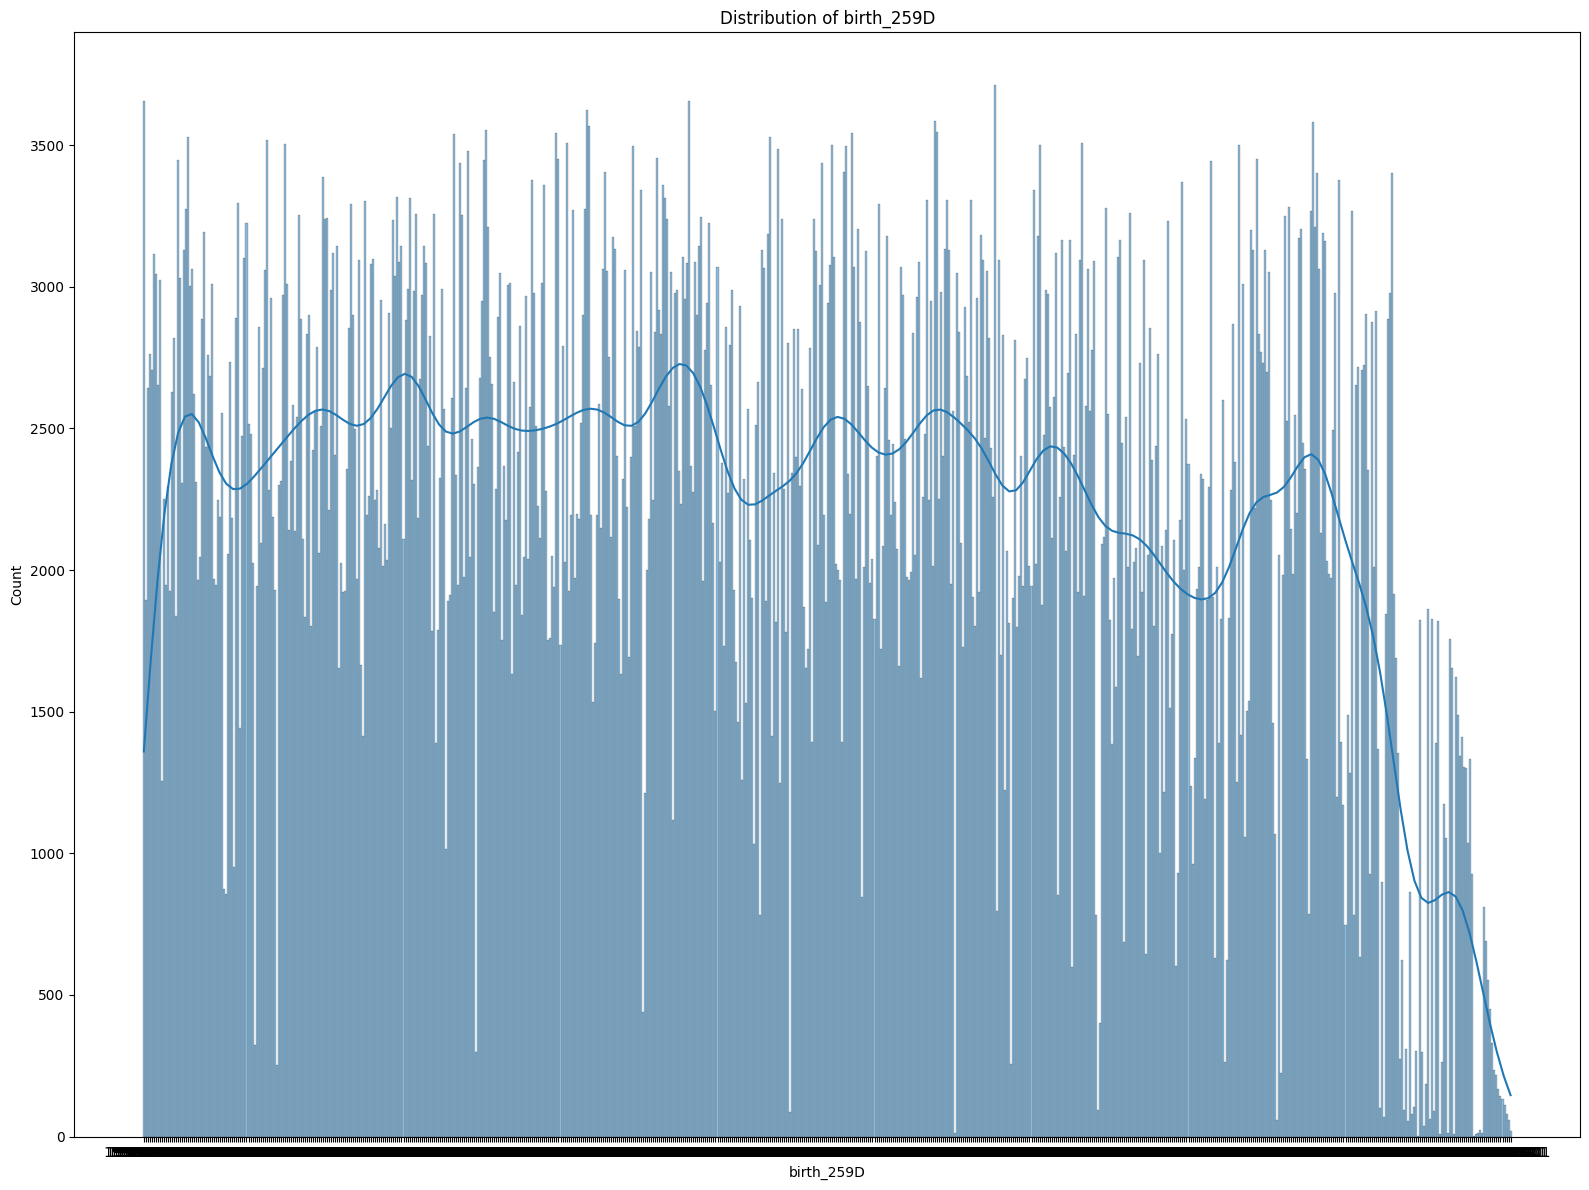

In [29]:
plot_feature_distributions(grapgg, figsize=(16, 12))

### Prediction of target

In [39]:
from sklearn.linear_model import SGDClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

In [41]:
# Separate majority and minority classes, because of compute performance and count of rows I downsample 
train_dwnsmpl_df = pd.concat([train_mod_df, y], axis = 1)
df_majority = train_dwnsmpl_df[train_dwnsmpl_df['target'] == 0]
df_minority = train_dwnsmpl_df[train_dwnsmpl_df['target'] == 1]


# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,  # sample without replacement
                                   n_samples=len(df_minority),  # to match minority class
                                   random_state=42)  # for reproducibility

# Combine minority class with downsampled majority class
train_balanced_df = pd.concat([df_majority_downsampled, df_minority])
#train_balanced_df = train_balanced_df.drop(columns=['target'])

In [ ]:
#Label Encoder because of compute performance during further processing
from sklearn.preprocessing import LabelEncoder

def label_encode_dataframe(df):
    # Make a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()
    
    # Initialize a dictionary to keep track of label encoders for each column
    label_encoders = {}
    
    # Iterate through each column in the DataFrame
    for col in df_copy.columns:
        if df_copy[col].dtype == 'object':
            # Initialize LabelEncoder for the column
            le = LabelEncoder()
            
            # Fit and transform the column
            df_copy[col] = le.fit_transform(df_copy[col].astype(str))
            
            # Store the label encoder in the dictionary
            label_encoders[col] = le
    
    return df_copy, label_encoders


# Apply label encoding
train_encod_df, encoders = label_encode_dataframe(train_balanced_df)

print("Encoded DataFrame:")
train_encod_df.head(10)
#print("\nLabel Encoders:")
#for col, le in encoders.items():
    #print(f"{col}: {le.classes_}")

In [43]:
pd.options.mode.copy_on_write = True #odstranění warningu
y = train_encod_df[['case_id', 'target']]
y.rename(columns = {'case_id':'index'}, inplace = True)
y = y.drop(columns=['index'])
new_submission = train_encod_df[['case_id']] #Uložení Id bokem
y.reset_index(drop=True).reset_index()
#y['Id'] = y['Id'] -1 ?
train_model_df = train_encod_df.drop(columns=['target', 'case_id'])
y.head()

,target
1059657,0
1131980,0
351856,0
642802,0
71575,0


In [44]:
# Split the data (not strictly necessary for DBSCAN, but kept for consistency)
y = y.apply(pd.to_numeric, errors='coerce')
# Scale features
scaler = StandardScaler()
scaler.fit(train_model_df)  # Fit the scaler to the entire dataset
train_model_df_scaled = scaler.transform(train_model_df)  # Scale the training data
X_train, X_test, y_train, y_test = train_test_split(train_model_df_scaled, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(y_train['target'].sum())

(71991, 335)
(71991, 1)
36038


In [45]:
import statsmodels.api as sm

# Assuming train_model_df contains your feature names
# Convert the scaled data back to DataFrame format with original column names
train_model_df_scaled = pd.DataFrame(train_model_df_scaled, columns=train_model_df.columns)

# Add a constant to the model (intercept)
X_train_const = sm.add_constant(X_train)

# Fit an OLS model
model = sm.OLS(y_train['target'], X_train_const).fit()

# Get the p-values
p_values = model.pvalues

# Create a DataFrame to display feature names and their p-values
p_values_df = pd.DataFrame({'Feature': ['const'] + list(train_model_df.columns), 'p-value': p_values})

# Remove the 'const' row
p_values_df = p_values_df[p_values_df['Feature'] != 'const']

# Print the p-values
pd.set_option('display.float_format', '{:.6e}'.format)
print(p_values_df.sort_values(by='p-value', ascending=True))

                                Feature       p-value
x33                            sex_738L 1.567061e-215
x105                lastdelinqdate_224D 2.334022e-157
x330                        pmtssum_45A  1.315305e-98
x251              lastdelinqdate_224D_1  6.021646e-82
x138                  mobilephncnt_593L  4.201961e-74
x112                 lastrejectdate_50D  1.475278e-63
x284                mobilephncnt_593L_1  9.848874e-54
x258               lastrejectdate_50D_1  4.896426e-25
x18                    incometype_1044T  5.561683e-25
x28           relationshiptoclient_415T  5.297632e-23
x169                        pmtnum_254L  8.509099e-23
x95                   interestrate_311L  3.870556e-22
x87                            eir_270L  3.870556e-22
x148            numinstlswithdpd10_728L  2.290040e-21
x294          numinstlswithdpd10_728L_1  2.038501e-16
x242               isbidproduct_1095L_1  6.144718e-16
x11              empl_employedfrom_271D  6.945588e-16
x109        lastrejectcommod

In [50]:
# assume you have a dataframe with target variable 'target'
# and you have trained an SGDClassifier model
#y_train = y_train.ravel()
#pd.set_option("display.precision", 5)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
pd.set_option('display.float_format', '{:.5f}'.format)

# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(train_model_df, y, test_size=0.25, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train.squeeze())

# Scale features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)

# Logistic Regression with hyperparameter tuning
model_LR = LogisticRegression(class_weight='balanced', max_iter = 1500, penalty='l2', solver='lbfgs') # or use class_weight={0: 1, 1: 2}
model_LR.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred = model_LR.predict(X_test)
print(classification_report(y_test, y_pred))
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (with higher precision): {f1:.10f}")

              precision    recall  f1-score   support

           0       0.72      0.71      0.71     12041
           1       0.71      0.72      0.71     11956

    accuracy                           0.71     23997
   macro avg       0.71      0.71      0.71     23997
weighted avg       0.71      0.71      0.71     23997

F1 Score (with higher precision): 0.7124976000


Confusion Matrix:
 [[8503 3538]
 [3361 8595]]


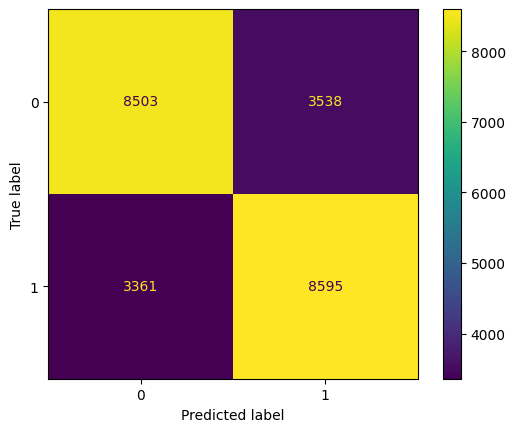

In [51]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Display confusion matrix
ConfusionMatrixDisplay(conf_matrix).plot()

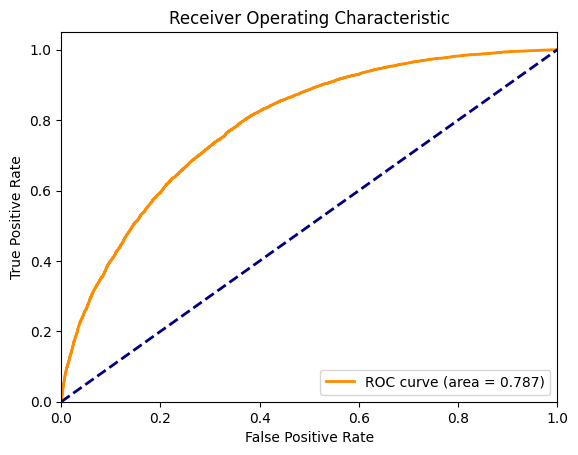

In [52]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_prob = model_LR.decision_function(X_test)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


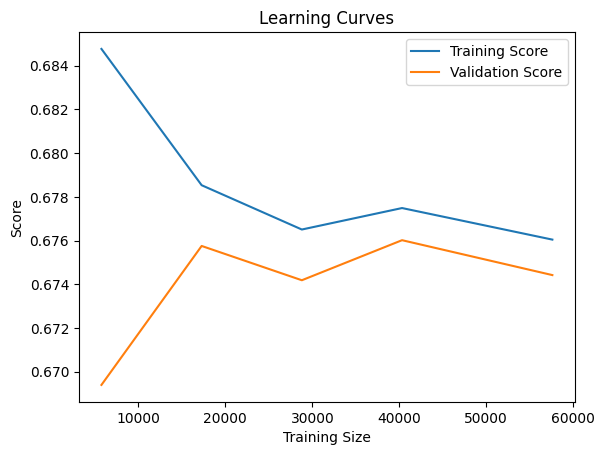

In [54]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    LogisticRegression(max_iter=1000), X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0]
)

# Plot learning curves
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
plt.plot(train_sizes, validation_scores.mean(axis=1), label='Validation Score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend()
plt.show()